# Best Photo Selection

*   Multilabel Image Classification. 6 classes are: bright, dark, good, lens flare, loss and motion blur.


## Deciding if a photograph is good or bad by the different classes with their confidence.

### Using original and synthetic data from [Flickr Image dataset](https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset) 

Train data is:

*   800 photos for each class (4800 in total).

Validation data is:

*   200 photos for each class (1200 in total).

Test data is:

*   100 photos for each class (600 in total).

### Step 1: Mount Google Drive

In [1]:
import pandas as pd
import numpy as np
import os
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 2: Data preparation

In [3]:
classes = os.listdir('drive/MyDrive/data/multiclass/train/')

In [4]:
from keras.preprocessing.image import ImageDataGenerator
img_gen = ImageDataGenerator(validation_split=0.0)

In [5]:
from keras.utils.np_utils import to_categorical

#train data
train_data = img_gen.flow_from_directory(
    'drive/MyDrive/data/multiclass/train/',
    class_mode='categorical',
    batch_size=64,
    target_size=(224, 224),
)

n_train_samples = len(train_data.filenames)  
num_classes = len(train_data.class_indices)

# get the class lebels for the training data, in the original order  
train_labels = train_data.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 4800 images belonging to 6 classes.


In [6]:
#validation data
valid_data = img_gen.flow_from_directory(
    'drive/MyDrive/data/multiclass/validation/',
    class_mode='categorical',
    batch_size=64,
    target_size=(224, 224),
)

n_validation_samples = len(valid_data.filenames)

valid_labels = valid_data.classes  
valid_labels = to_categorical(valid_labels, num_classes=num_classes)  

Found 1200 images belonging to 6 classes.


In [7]:
print('there are' ,n_train_samples,'images in the training set and', len(train_data), 'mini-batches')
print('there are' ,n_validation_samples,'images in the validation set and', len(valid_data), 'mini-batches')

there are 4800 images in the training set and 75 mini-batches
there are 1200 images in the validation set and 19 mini-batches


### Step 3: An advanced model using inceptionV3

In [8]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
from tensorflow.keras.applications import InceptionV3
inceptionV3_model = InceptionV3(input_shape=(224, 224,3), include_top=False, weights="imagenet")

87924736/87910968 [==============================] - 0s 0us/step


In [10]:
for layer in inceptionV3_model.layers:
    layer.trainable = False

In [11]:
print('there are', len(inceptionV3_model.layers), 'layers in inceptionV3_model')
print('there are', inceptionV3_model.count_params(), 'parameters in inceptionV3_model')

there are 311 layers in inceptionV3_model
there are 21802784 parameters in inceptionV3_model


In [12]:
print('input shape is', inceptionV3_model.input_shape)
print('output shape is', inceptionV3_model.output_shape)
inceptionV3_model.summary()

input shape is (None, 224, 224, 3)
output shape is (None, 5, 5, 2048)
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)      

In [13]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

inceptionV3_model = Sequential()
inceptionV3_model.add(InceptionV3(include_top=False, weights='imagenet', pooling='max'))
inceptionV3_model.add(Dense(num_classes, activation='softmax'))

In [14]:
checkpoint_path = "training_1/InceptionV3.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [15]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [16]:
inceptionV3_model.compile(optimizer = 'SGD', loss = 'categorical_crossentropy', metrics = ['acc'])

In [17]:
# Training the model for 10 epochs
history = inceptionV3_model.fit(train_data, steps_per_epoch = 100, validation_data = valid_data, validation_steps = 100, epochs = 10, callbacks=[cp_callback])

Epoch 1/10
100/100 [==============================] - 1899s 19s/step - loss: 1.2280 - acc: 0.7116 - val_loss: 0.4996 - val_acc: 0.8228

Epoch 1: saving model to training_1/InceptionV3.ckpt
Epoch 2/10
100/100 [==============================] - 82s 824ms/step - loss: 0.1121 - acc: 0.9636 - val_loss: 0.1668 - val_acc: 0.9400

Epoch 2: saving model to training_1/InceptionV3.ckpt
Epoch 3/10
100/100 [==============================] - 83s 838ms/step - loss: 0.0282 - acc: 0.9928 - val_loss: 0.1422 - val_acc: 0.9478

Epoch 3: saving model to training_1/InceptionV3.ckpt
Epoch 4/10
100/100 [==============================] - 84s 841ms/step - loss: 0.0154 - acc: 0.9966 - val_loss: 0.1424 - val_acc: 0.9477

Epoch 4: saving model to training_1/InceptionV3.ckpt
Epoch 5/10
100/100 [==============================] - 82s 828ms/step - loss: 0.0098 - acc: 0.9983 - val_loss: 0.1320 - val_acc: 0.9524

Epoch 5: saving model to training_1/InceptionV3.ckpt
Epoch 6/10
100/100 [==============================] - 8

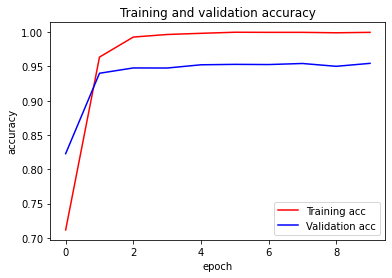

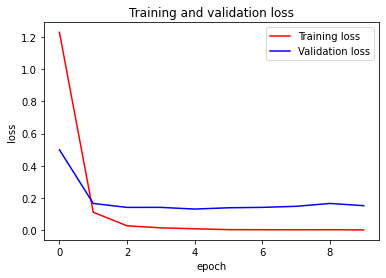

In [19]:
from matplotlib import pyplot as plt

#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [20]:
os.listdir(checkpoint_dir)

['InceptionV3.ckpt.index',
 'checkpoint',
 'InceptionV3.ckpt.data-00000-of-00001']

#### Pickling the model

In [21]:
tf.keras.models.save_model(inceptionV3_model, 'training_1/inceptionV3_model_final')

INFO:tensorflow:Assets written to: training_1/inceptionV3_model_final/assets


#### Zip the model and train data and download the files to local computer

In [23]:
!zip -r /content/model.zip /content/training_1

  adding: content/training_1/ (stored 0%)
  adding: content/training_1/inceptionV3_model_final/ (stored 0%)
  adding: content/training_1/inceptionV3_model_final/saved_model.pb (deflated 93%)
  adding: content/training_1/inceptionV3_model_final/assets/ (stored 0%)
  adding: content/training_1/inceptionV3_model_final/keras_metadata.pb (deflated 96%)
  adding: content/training_1/inceptionV3_model_final/variables/ (stored 0%)
  adding: content/training_1/inceptionV3_model_final/variables/variables.index (deflated 76%)
  adding: content/training_1/inceptionV3_model_final/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/training_1/InceptionV3.ckpt.index (deflated 80%)
  adding: content/training_1/checkpoint (deflated 40%)
  adding: content/training_1/InceptionV3.ckpt.data-00000-of-00001 (deflated 7%)


In [24]:
from google.colab import files
files.download("/content/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Step 4: testing the model

In [29]:
import tensorflow_hub as hub

inceptionV3_model = tf.keras.Sequential([
    hub.KerasLayer("training_1/inceptionV3_model_final")
])
inceptionV3_model.build([None, 224, 224, 3])

In [30]:
inceptionV3_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6)                 21815078  
                                                                 
Total params: 21,815,078
Trainable params: 0
Non-trainable params: 21,815,078
_________________________________________________________________


In [31]:
test_data = img_gen.flow_from_directory(
    'drive/MyDrive/data/multiclass/test/',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False,
)

n_test_samples = len(test_data.filenames)     

test_labels = test_data.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 600 images belonging to 6 classes.


In [32]:
print('test data', test_data)
preds = np.round(inceptionV3_model.predict(test_data), 0) 

test data <keras.preprocessing.image.DirectoryIterator object at 0x7f7ea70e8050>


#### Confusion matrix

In [33]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

In [35]:
import itertools
import seaborn as sns

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


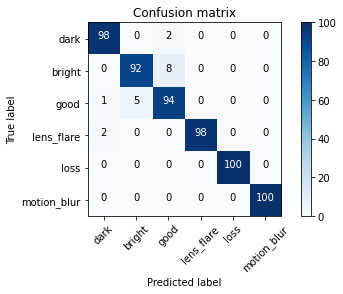

In [36]:
plot_confusion_matrix(confusion_matrix, classes)

Normalized confusion matrix


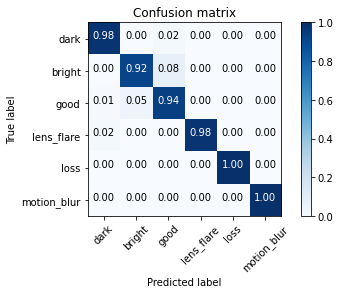

In [37]:
#Those numbers are all over the place. Now turning normalize = True
plot_confusion_matrix(confusion_matrix, classes, normalize=True)

#### Classification report

In [38]:
from sklearn import metrics
classification_metrics = metrics.classification_report(test_labels, preds, target_names=classes)
print(classification_metrics)

              precision    recall  f1-score   support

        dark       0.98      0.98      0.98       100
      bright       0.95      0.92      0.93       100
        good       0.90      0.94      0.92       100
  lens_flare       1.00      0.98      0.99       100
        loss       1.00      1.00      1.00       100
 motion_blur       1.00      1.00      1.00       100

   micro avg       0.97      0.97      0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600
 samples avg       0.97      0.97      0.97       600



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Evaluating samples of test data

In [39]:
from tensorflow.keras.utils import img_to_array, load_img

In [40]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    # image /= 255.  
    return image

In [41]:
def test_single_image(path):
    images = read_image(path)
    preds = inceptionV3_model.predict(images)
    for idx, layer, x in zip(range(0,6), classes , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, layer, np.round(x*100,2) ))
    print('Final Decision:')
    for x in range(3):
        print('.'*(x+1))
    class_predicted = np.argmax(preds, axis=1)
    class_dictionary = test_data.class_indices
    inv_map = {v: k for k, v in class_dictionary.items()} 
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))
    return load_img(path)

In [54]:
path = '/content/drive/MyDrive/data/multiclass/single images for testing/6.jpg'

[INFO] loading and preprocessing image...
ID: 0, Label: dark 0.2%
ID: 1, Label: bright 0.0%
ID: 2, Label: good 0.09%
ID: 3, Label: lens_flare 99.7%
ID: 4, Label: loss 0.0%
ID: 5, Label: motion_blur 0.01%
Final Decision:
.
..
...
ID: 3, Label: lens_flare


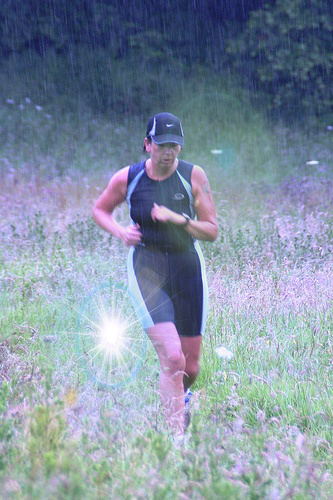

In [55]:
test_single_image(path)